# MNIST Digit Images Classification using PyTorch.

In [6]:
#Importing all libraries
import time
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from collections import OrderedDict

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [7]:
#Import data
train_df = pd.read_csv("../input/digit-recognizer/train.csv")
test_df = pd.read_csv("../input/digit-recognizer/test.csv")

In [8]:
#Labels(Targets) and Inputs
train_labels = train_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_images = (test_df.iloc[:,:].values).astype('float32')

#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, 
                                                                      train_labels,
                                                                     stratify=train_labels, 
                                                                      random_state=62,
                                                                     test_size=0.20)

In [9]:
#Reshaping
train_images = train_images.reshape(train_images.shape[0], 28, 28)
val_images = val_images.reshape(val_images.shape[0], 28, 28)
test_images = test_images.reshape(test_images.shape[0], 28, 28)

In [10]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)
#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)
#test
test_images_tensor = torch.tensor(test_images)/255.0

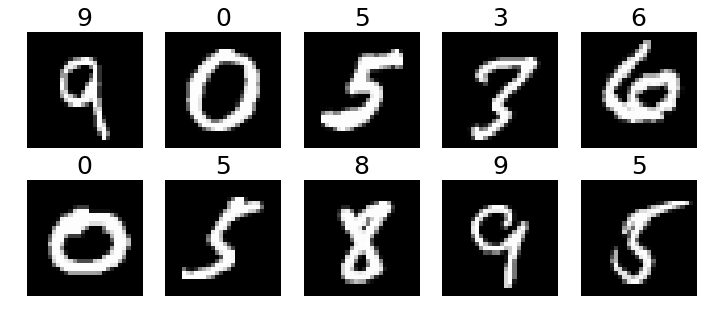

In [11]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,5000,size=10)
for i in range(10):
    axes[i].imshow(train_images[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(train_labels[idx[i]])), color= 'black', fontsize=25)
plt.show()

In [12]:
#Dataloader
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
device

device(type='cpu')

## Logistic Regression Model

In [14]:
class Logistic_Regression(nn.Module):
    def __init__(self, input_dimension, output_dimension):
        super(Logistic_Regression, self).__init__() 
        self.linear = nn.Linear(input_dimension, output_dimension)
        
    def forward(self, x):
        output = self.linear(x)
        return output

In [15]:
input_dim = 28*28
output_dim = 10

log_model = Logistic_Regression(input_dim, output_dim)
log_model.to(device)

Logistic_Regression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [16]:
batch_size = 100
n_iters = 2000
num_epochs = int(n_iters / (len(train_images) / batch_size))

learning_rate = 0.1
num_epochs

5

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(log_model.parameters(), lr=learning_rate)

In [18]:
train_losses, test_losses = [], []
iter = 0
for epoch in tqdm(range(num_epochs)):
    train_loss = 0.
    test_loss = 0.
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = log_model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
                
        train_loss += loss.item()*images.size(0)
        
        iter += 1

        if iter % 100 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through validation dataset
            for images, labels in val_loader:
                images = images.view(-1, 28*28).requires_grad_().to(device)

                # Forward pass only to get logits/output
                outputs = log_model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)
                test_loss += loss.item()*images.size(0)
                
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            #print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            train_loss = train_loss/len(train_loader.sampler)
            test_loss = test_loss/len(test_loader.sampler)
            
            train_losses.append(train_loss/len(train_loader.sampler))
            test_losses.append(test_loss/len(test_loader.sampler)) 

100%|██████████| 5/5 [02:15<00:00, 27.18s/it]


In [19]:
print('Final Loss: {}, Final Accuracy: {} %'.format(loss.item(), accuracy))

Final Loss: 0.5419744849205017, Final Accuracy: 91 %


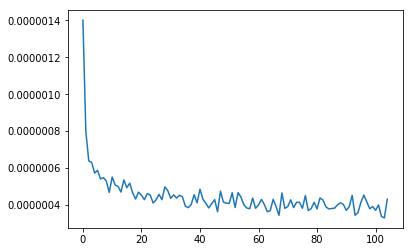

In [20]:
plt.plot(train_losses)

## Multi Layered Perceptron

In [21]:
class MLP(nn.Module):
    def __init__(self, inputs, hidden_1, hidden_2,outputs):
        super(MLP, self).__init__()
        #layers: [In-h1-h2-Out]
        self.fc1 = nn.Linear(inputs, hidden_1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.relu2 = nn.ReLU() 
        self.fc3 = nn.Linear(hidden_2, outputs)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [22]:
mlp = MLP(784, 512, 512, 10).to(device)
mlp

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)

In [23]:
criterion = nn.CrossEntropyLoss()
batch_size = 100
n_iters = 3000
num_epochs = int(n_iters / (len(train_images) / batch_size))

learning_rate = 0.1
optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate)

In [24]:
train_losses, test_losses = [], []
iter = 0
for epoch in tqdm(range(num_epochs)):
    train_loss = 0.
    test_loss = 0.
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = mlp(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 100 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in val_loader:
                images = images.view(-1, 28*28).requires_grad_().to(device)

                # Forward pass only to get logits/output
                outputs = mlp(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            #print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

100%|██████████| 8/8 [04:59<00:00, 37.44s/it]


In [25]:
print('Loss: {}, Accuracy: {}%'.format(loss.item(), accuracy))

Loss: 0.00010397352889413014, Accuracy: 97%


## Predictions

In [30]:
def make_predictions(data_loader, model):
    model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        data = data.view(data.size(0), -1)
        output = model(data)
        
        preds = output.data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds

In [31]:
test_set_preds = make_predictions(test_loader, mlp)
test_new = TensorDataset(test_images_tensor, test_set_preds)
testnew = DataLoader(test_new, batch_size=16, num_workers=2, shuffle=False)

## Submission

In [32]:
sub = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
sub['Label'] = test_set_preds.numpy().squeeze()
sub.to_csv("MLP_new.csv", index=False)
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
